# Query Expansion  (Advanced RAG technique)

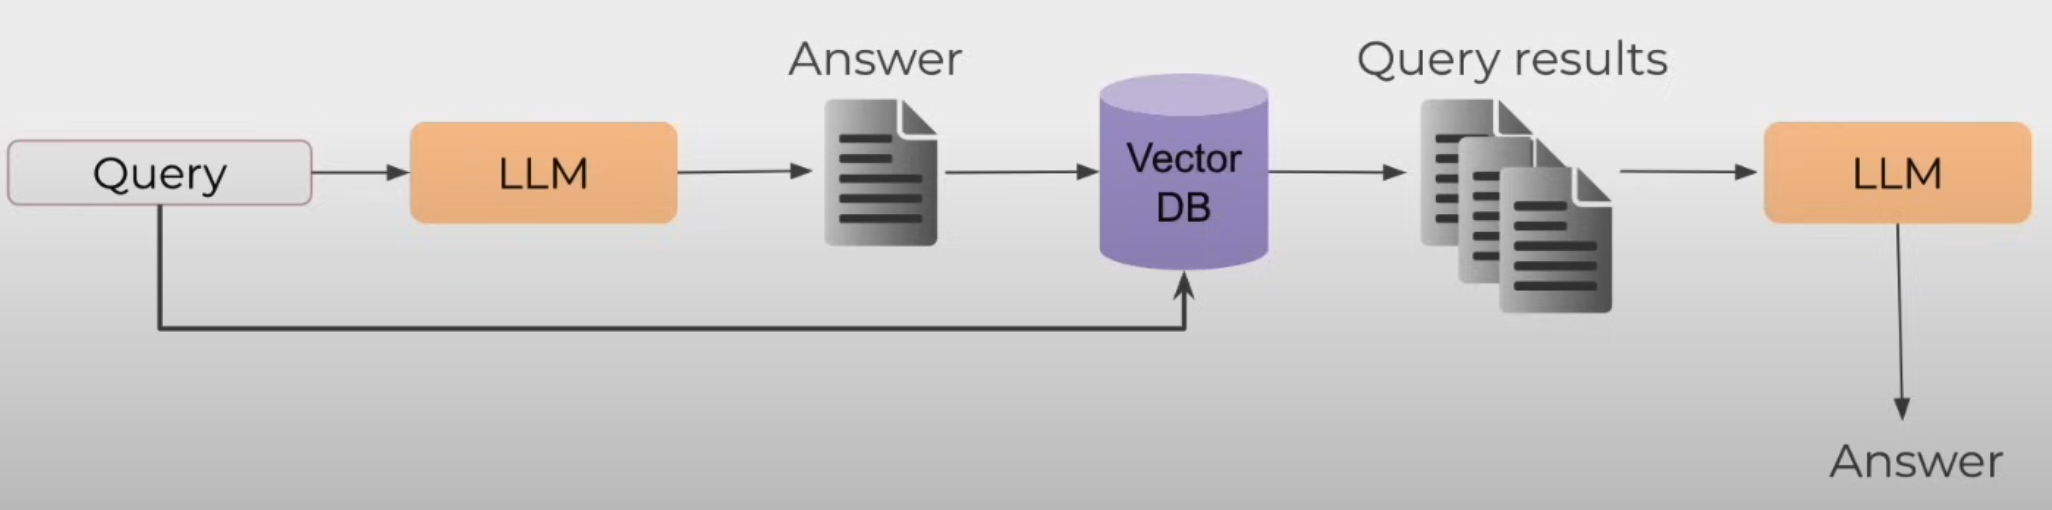

In [98]:
from pypdf import PdfReader
import os
from openai import OpenAI
from dotenv import load_dotenv
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import textwrap
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt


**laod the enviroment of openAI**


In [4]:
# Load environment variables from .env file
load_dotenv()
openai_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=openai_key)

# Step 1: Read all PDFs in the folder


In [7]:
# Folder containing PDFs
pdf_folder = "documents"

# List all PDFs in the folder
pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]

# Extract text from all PDFs
pdf_texts = []


In [8]:
for pdf_file in pdf_files:
    pdf_path = os.path.join(pdf_folder, pdf_file)
    reader = PdfReader(pdf_path)

    # Extract text from all pages and filter out empty strings
    pdf_texts.extend([p.extract_text().strip() for p in reader.pages if p.extract_text()])


In [12]:
#This will show you all the PDFs inside "data" so you know which one to inspect.

pdf_folder = "documents"
pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]

print("Available PDFs:")
for i, file in enumerate(pdf_files, start=1):
    print(f"{i}. {file}")


Available PDFs:
1. guide-to-the-general-data-protection-regulation-gdpr-1-0.pdf
2. CASL-Model-Language-2014-05.pdf
3. beps-2014-deliverables-information-brief.pdf
4. GAAP_Guide_Sheet_508.pdf
5. A Guide to ESG Standards and Frameworks.pdf
6. 19-0017 (Consumer Privacy ).pdf
7. ESG-101-Guide_Feb2024.pdf
8. california-privacy-rights-act-a-compliance-guide.pdf
9. COMPS-1883.pdf
10. ifrs-issued-standards-2022-part-a.pdf


In [13]:

for pdf_file in pdf_files:
    pdf_path = os.path.join(pdf_folder, pdf_file)
    reader = PdfReader(pdf_path)

    if len(reader.pages) > 0:
        print(f"\n--- First Page of '{pdf_file}' ---\n")
        print(reader.pages[0].extract_text())
    else:
        print(f"\n'{pdf_file}' has no pages or text.")


--- First Page of 'guide-to-the-general-data-protection-regulation-gdpr-1-0.pdf' ---

Guide to the
General Data Protection
Regulation (GDPR)
Data protection

--- First Page of 'CASL-Model-Language-2014-05.pdf' ---

 
 
Canadian Anti-Spam Legislation (CASL) 
MODEL LANGUAGE 
 
The following language is recommended to comply with UBC’s requirements under the CASL. Variations 
of this language are acceptable as long as they comply with the legal requirements. This document 
should be read in conjunction with the Frequently Asked Questions (FAQs). 
 
1. Requests for Express Consent  
Legal requirements: You cannot send someone Commercial Electronic Messages unless you have their 
consent. Requests for express consent must contain the following information: 
 
(a) the specific purpose for which you’re seeking their consent 
(b) the name of the UBC unit seeking consent 
(c) the following contact information for the UBC unit seeking consent (or a link to a website containing 
this information

In [14]:
pdf_texts = [text for text in pdf_texts if text]

In [15]:
# Join all texts into a single document
pdf_text_combined = "\n\n".join(pdf_texts)

# Step 2: Combine text and apply character-level chunking


In [17]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=100
)

# Split text into chunks
chunks = character_splitter.split_text(pdf_text_combined)

print(f"Total Chunks: {len(chunks)}")
print("\nFirst Chunk Preview:\n", chunks[0])

Total Chunks: 1381

First Chunk Preview:
 Guide to the
General Data Protection
Regulation (GDPR)
Data protection


# Step 3: Apply token-based chunking

In [19]:

token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=20, tokens_per_chunk=256
)
token_split_texts = [
    chunk for text in chunks
    for chunk in token_splitter.split_text(text)
]

In [20]:
# Debugging: Print first few chunks
print(f"Total Character Chunks: {len(chunks)}")
print(f"Total Token Chunks: {len(token_split_texts)}")
print("\nFirst Token-Based Chunk Preview:\n", token_split_texts[0])

Total Character Chunks: 1381
Total Token Chunks: 1391

First Token-Based Chunk Preview:
 guide to the general data protection regulation ( gdpr ) data protection


# Embeddings in ChromaDB


In [22]:
# Define embedding function using a pre-trained model
embedding_function = SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")

In [23]:
print(embedding_function([token_split_texts[10]]))

[array([-5.26071750e-02,  7.87316263e-02, -2.13372670e-02,  5.01598045e-03,
        4.27101888e-02,  2.35501621e-02,  7.69746350e-03,  7.17110038e-02,
       -1.04959197e-02,  3.79293747e-02,  4.14574221e-02,  1.27108693e-02,
       -3.08764242e-02,  2.77998354e-02,  2.40014922e-02,  5.01291081e-02,
        2.67950017e-02, -3.22499983e-02, -6.10118806e-02, -3.16437036e-02,
       -3.51412259e-02,  6.59268647e-02,  5.71438223e-02, -4.60028537e-02,
       -6.48551583e-02,  3.20426971e-02,  3.57339233e-02, -1.11601464e-01,
        8.26684944e-03,  2.04540659e-02,  5.26796989e-02,  2.59265900e-02,
        2.20498964e-02,  4.51480560e-02,  2.32937131e-02, -8.39420184e-02,
        9.46872458e-02,  1.88380741e-02,  2.43872162e-02,  1.16938213e-02,
        2.80836932e-02, -7.36416131e-02, -8.18211213e-02,  9.27388389e-03,
       -2.90556811e-02,  7.65395164e-03, -5.95023972e-04, -2.74045505e-02,
       -6.29957616e-02,  2.70646065e-02, -1.31911278e-01, -7.65857920e-02,
        3.48444954e-02, 

In [24]:
# Initialize ChromaDB Persistent Client (ensures data isn't lost)
db_path = "chroma_db"  # Change this to set a custom storage directory
chroma_client = chromadb.PersistentClient(path=db_path)

In [25]:
# Create or get the collection
chroma_collection = chroma_client.get_or_create_collection(
    name="microsoft-collection", embedding_function=embedding_function
)

In [26]:
# Ensure token_split_texts is not empty
if not token_split_texts:
    raise ValueError("No text chunks available for embedding!")


In [27]:
# Generate unique document IDs
ids = [str(i) for i in range(len(token_split_texts))]

In [28]:
# Add documents to ChromaDB collection
chroma_collection.add(
    ids=ids, 
    documents=token_split_texts,
    metadatas=[{"chunk_id": i} for i in range(len(token_split_texts))]  # Optional metadata
)

In [29]:
# Confirm the number of stored embeddings
print(f"Total Chunks Stored in ChromaDB: {chroma_collection.count()}")

Total Chunks Stored in ChromaDB: 1391


In [30]:
# Retrieve one stored document
sample_result = chroma_collection.get(ids=["0"])  # Get first stored chunk
print("\nStored Text Chunk:\n", sample_result["documents"])
print("\nStored Metadata:\n", sample_result["metadatas"])



Stored Text Chunk:
 ['guide to the general data protection regulation ( gdpr ) data protection']

Stored Metadata:
 [{'chunk_id': 0}]


# Query Your ChromaDB Collection

In [32]:
query = "What are the differences between GAAP and IFRS?"

In [33]:
# Retrieve top 5 relevant chunks
results = chroma_collection.query(query_texts=[query], n_results=5)

In [34]:
# Extract retrieved documents and metadata
retrieved_documents = results["documents"][0]
retrieved_metadata = results["metadatas"][0]  # If metadata was stored

In [35]:
if not retrieved_documents:
    print("❌ No relevant results found.")
else:
    print("🔎 ** Top Retrieved Chunks: **\n")
    
    for i, document in enumerate(retrieved_documents):
        print(f"🔹 Result {i+1}  (Chunk ID: {retrieved_metadata[i]['chunk_id']})")
        print(textwrap.fill(document, width=100))  # Wrap text neatly
        print("\n" + "-"*80 + "\n")

🔎 ** Top Retrieved Chunks: **

🔹 Result 1  (Chunk ID: 1383)
ifrs® standards issued at 1 january 2022, reflecting changes not yet required this edition is issued
in three parts part a contains the text of ifrs standards including ias® standards, ifric®
interpretations and sic® interpretations, together with the conceptual framework for financial
reporting ( glossary included ) see also parts b and c of this edition : part b contains the
illustrative examples and implementation guidance that accompany the standards, together with ifrs
practice statements part c contains the bases for conclusions that accompany the standards, the
conceptual framework for financial reporting and ifrs practice statements, together with the
constitution and due process handbook of the ifrs foundation

--------------------------------------------------------------------------------

🔹 Result 2  (Chunk ID: 799)
1 generally accepted accounting principles ( gaap ) guide sheet grant financial management requir
em

# Query Expansion  (Advanced RAG technique)

In [36]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    """
    Uses GPT to generate an improved search query for better document retrieval.
    """
    prompt = """You are a helpful financial research assistant. 
    Rephrase or expand the given question to improve document search accuracy."""

    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0.3  # Lower temp for better precision
    )
    
    content = response.choices[0].message.content
    return content

In [79]:
# Original user query
original_query = "How does corporate taxation affect financial reporting?"

In [80]:
# Generate a GPT-augmented query
hypothetical_answer = augment_query_generated(original_query)

In [81]:
# Combine original query + GPT-generated answer
joint_query = f"{original_query} {hypothetical_answer}"

In [82]:
# Print the modified query
print("\n🔹 Augmented Query:\n")
print(textwrap.fill(joint_query, width=100))  # Use textwrap.fill for clean formatting


🔹 Augmented Query:

How does corporate taxation affect financial reporting? How do corporate taxes impact financial
reporting practices within organizations?


In [83]:
# Query ChromaDB with the improved query
results = chroma_collection.query(
    query_texts=[joint_query],  
    n_results=5,  
    include=["documents", "embeddings", "metadatas", "distances"]  # Explicitly request embeddings
)


In [84]:
# Extract retrieved documents
retrieved_documents = results["documents"][0]

In [85]:
# Print retrieved chunks
print("\n🔎 **Top Retrieved Chunks:**\n")
for i, doc in enumerate(retrieved_documents):
    print(f"🔹 Result {i+1}:  (Chunk ID: {retrieved_metadata[i]['chunk_id']})")
    print(textwrap.fill(doc, width=100))  # Wrap long text for better readability
    print("\n" + "-"*80 + "\n")


🔎 **Top Retrieved Chunks:**

🔹 Result 1:  (Chunk ID: 1383)
events, the board shall protect from public disclosure information reasonably identified by the
subject accounting firm as proprietary information. ( f ) r egistration and annual fees. — the board
shall assess and collect a registration fee and an annual fee from each reg - istered public
accounting firm, in amounts that are sufficient to re - cover the costs of processing and reviewing
applications and annual reports. sec. 103. ø15 u. s. c. 7213 ¿ auditing, quality control, and inde -
pendence standards and rules. ( a ) auditing, quality control, and ethics standards. — ( 1 ) i n
general. — the board shall, by rule, establish, in - cluding, to the extent it determines
appropriate, through adop - tion of standards proposed by 1 or more professional groups of
accountants designated pursuant to paragraph ( 3 ) ( a ) or advi - sory groups convened pursuant to
paragraph ( 4 ), and amend or otherwise modify or alter, such auditing 

idk i just feel they are same thing 

# performing UMAP dimensionality reduction

to visualize how embeddings are structured in vector space. This is useful for understanding how well queries and documents align.

In [87]:
# Retrieve stored embeddings from ChromaDB
embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]

In [88]:
# Ensure embeddings are in the correct format
embeddings = np.array(embeddings)  # Convert to NumPy array if needed

In [89]:
# Apply UMAP dimensionality reduction
umap_transform = umap.UMAP(n_components=2, random_state=0, transform_seed=0).fit(embeddings)

/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [90]:
# Function to project embeddings
def project_embeddings(embeddings, umap_model):
    """Projects high-dimensional embeddings into a 2D space using UMAP."""
    return umap_model.transform(np.array(embeddings))

In [91]:
# Project dataset embeddings
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [92]:
# Retrieve the embeddings for the retrieved chunks
retrieved_embeddings = np.array(results["embeddings"][0])

In [93]:
# Compute embeddings for the queries
original_query_embedding = np.array(embedding_function([original_query]))
augmented_query_embedding = np.array(embedding_function([joint_query]))

In [94]:
# Project queries into the same space
projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

print("✅ UMAP projection completed successfully!")

✅ UMAP projection completed successfully!


/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Visualize Embeddings

In [96]:
print(f"Dataset Embeddings Shape: {projected_dataset_embeddings.shape}")
print(f"Retrieved Embeddings Shape: {projected_retrieved_embeddings.shape}")
print(f"Original Query Shape: {projected_original_query_embedding.shape}")
print(f"Augmented Query Shape: {projected_augmented_query_embedding.shape}")


Dataset Embeddings Shape: (1391, 2)
Retrieved Embeddings Shape: (5, 2)
Original Query Shape: (1, 2)
Augmented Query Shape: (1, 2)


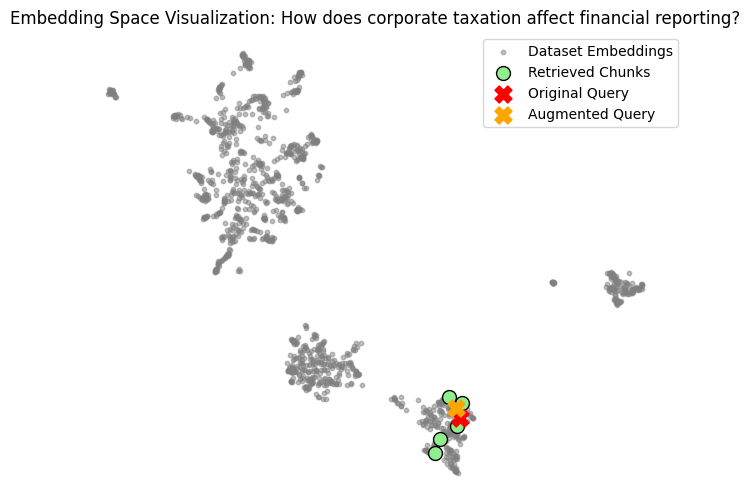

In [97]:

# Create plot
plt.figure(figsize=(8, 6))

# Dataset embeddings (gray background points)
plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
    alpha=0.5,
    label="Dataset Embeddings",
)

# Retrieved embeddings (green circles)
plt.scatter(
    projected_retrieved_embeddings[:, 0],
    projected_retrieved_embeddings[:, 1],
    s=100,
    color="lightgreen",
    edgecolors="black",
    label="Retrieved Chunks",
)

# Original query (red X)
plt.scatter(
    projected_original_query_embedding[:, 0],
    projected_original_query_embedding[:, 1],
    s=150,
    marker="X",
    color="red",
    label="Original Query",
)

# Augmented query (orange X)
plt.scatter(
    projected_augmented_query_embedding[:, 0],
    projected_augmented_query_embedding[:, 1],
    s=150,
    marker="X",
    color="orange",
    label="Augmented Query",
)

# Improve readability
plt.gca().set_aspect("equal", "datalim")
plt.title(f"Embedding Space Visualization: {original_query}")
plt.axis("off")  # Hide axis for cleaner visualization
plt.legend()  # Add legend for labels

# Show the plot
plt.show()

ommmmggg

yeah they are not that diff from each other because see the data they are a little far from the other data beacuse it's about ESG not financial 

--------------------------------------------------------------------



# Query Expansion - multiple queries (Advanced RAG technique)

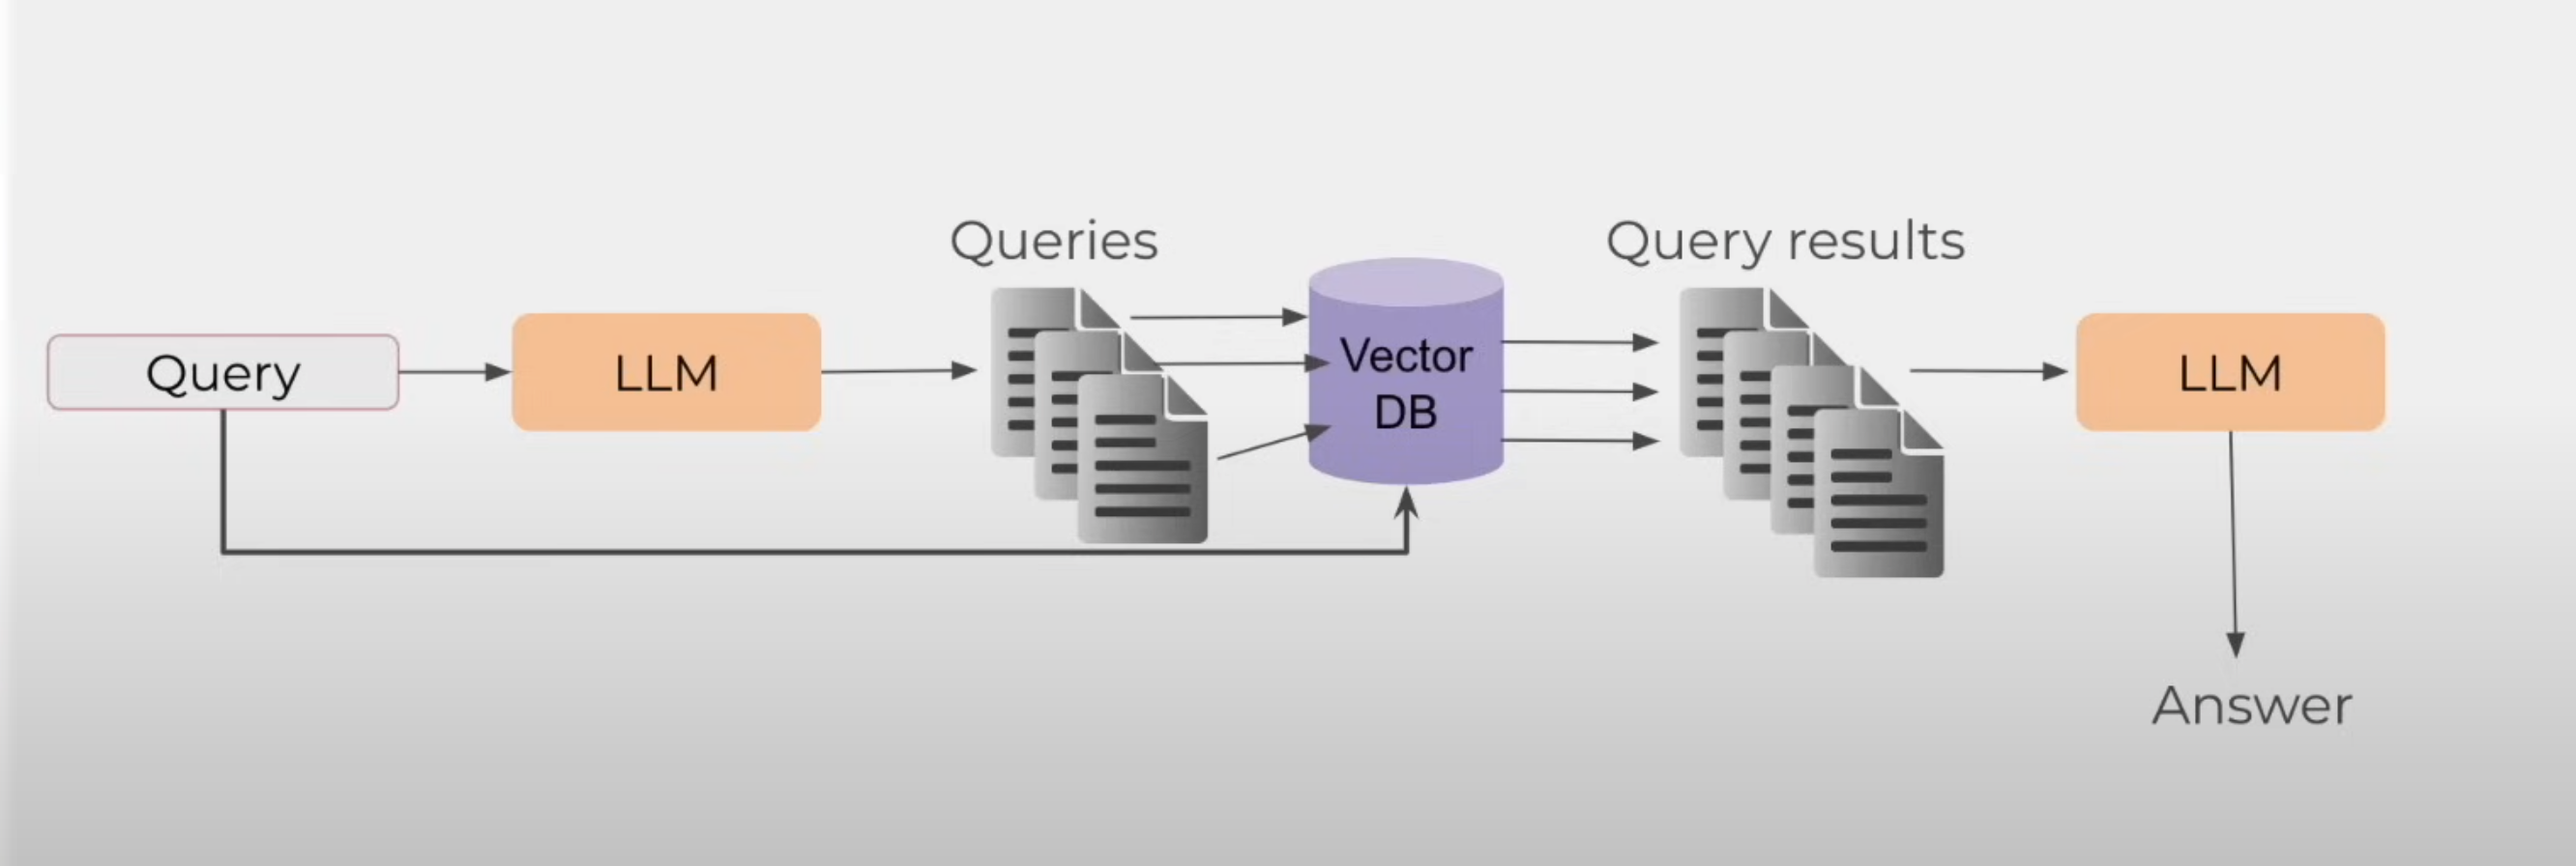

In [56]:
def generate_multi_query(query, model="gpt-3.5-turbo"):
    """Generate up to 5 diverse, related queries to enhance retrieval accuracy."""
    
    prompt = """
    You are a financial research assistant helping users analyze annual reports.
    For the given query, generate up to five related but diverse questions covering:
    - Revenue trends
    - Market conditions
    - Financial ratios
    - Growth drivers
    Ensure each question is precise, complete, and focuses on a unique aspect.
    List each question on a new line without numbering.
    """

    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(model=model, messages=messages)
    
    # Clean up response
    content = response.choices[0].message.content.split("\n")
    content = [q.strip() for q in content if q.strip()]  # Remove empty queries

    return content

In [69]:
# Original financial query
original_query = "How does corporate taxation affect financial reporting?"
aug_queries = generate_multi_query(original_query)

In [70]:
# Print augmented queries
print("\n🔹 Generated Augmented Queries:")
for q in aug_queries:
    print(f"- {q}")


🔹 Generated Augmented Queries:
- - How does changes in corporate taxation rates impact a company's revenue trends over the years?
- - What market conditions can influence the effectiveness of tax planning strategies on a company's financial performance?
- - How do variations in tax laws and regulations affect key financial ratios such as profit margins and return on equity?
- - What are some growth drivers that companies can leverage to mitigate the impact of higher corporate taxation on their bottom line?
- - How can a company communicate the impact of corporate taxation in its annual report to ensure transparency with investors and stakeholders?


In [71]:
# Combine original query with generated ones
joint_query = [original_query] + aug_queries

In [72]:
# Query ChromaDB
results = chroma_collection.query(
    query_texts=joint_query, 
    n_results=5, 
    include=["documents", "embeddings"]
)
retrieved_documents = results["documents"]

In [73]:
# Deduplicate documents
unique_documents = set()
for docs in retrieved_documents:
    for doc in docs:
        unique_documents.add(doc)

In [74]:
# Print results
print("\n🔎 **Retrieved Documents:**")
for i, docs in enumerate(retrieved_documents):
    print(f"\nQuery: {joint_query[i]}\n")
    print("Results:")
    for doc in docs:
        print(textwrap.fill(doc, width=100))
        print("-" * 80)


🔎 **Retrieved Documents:**

Query: How does corporate taxation affect financial reporting?

Results:
50 sec. 1001 sarbanes - oxley act of 2002 title x — corporate tax returns sec. 1001. sense of the
senate regarding the signing of cor - porate tax returns by chief executive officers. it is the
sense of the senate that the federal income tax re - turn of a corporation should be signed by the
chief executive officer of such corporation. title xi — corporate fraud accountability sec. 1101.
ø15 u. s. c. 78a note ¿ short title. this title may be cited as the ‘ ‘ corporate fraud
accountability act of 2002 ’ ’. * * * * * * * sec. 1104. ø28 u. s. c. 994 note ¿ amendment to the
federal sen - tencing guidelines. ( a ) r equest for immediate consideration by the united states
sentencing commission. — pursuant to its authority under section 994 ( p ) of title 28, united
states code, and in accordance with this section, the united states sentencing commission is re -
quested to — ( 1 ) promptly re

In [75]:
# Retrieve embeddings for visualization
embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(n_components=2, random_state=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [76]:
# Project query and retrieved embeddings
original_query_embedding = np.array(embedding_function([original_query]))
augmented_query_embeddings = np.array(embedding_function(aug_queries))
projected_original_query = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

retrieved_embeddings = [item for sublist in results["embeddings"] for item in sublist]
projected_result_embeddings = project_embeddings(retrieved_embeddings, umap_transform)
print("\n✅ Query expansion and retrieval completed successfully!")


✅ Query expansion and retrieval completed successfully!


/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanouf/Desktop/RAGfirstTry/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [77]:
# Debugging: Check shapes of embeddings before plotting
print(f"Dataset Embeddings Shape: {projected_dataset_embeddings.shape}")
print(f"Augmented Queries Shape: {projected_augmented_queries.shape}")
print(f"Retrieved Embeddings Shape: {projected_result_embeddings.shape}")
print(f"Original Query Shape: {projected_original_query.shape}")


Dataset Embeddings Shape: (1391, 2)
Augmented Queries Shape: (5, 2)
Retrieved Embeddings Shape: (30, 2)
Original Query Shape: (1, 2)


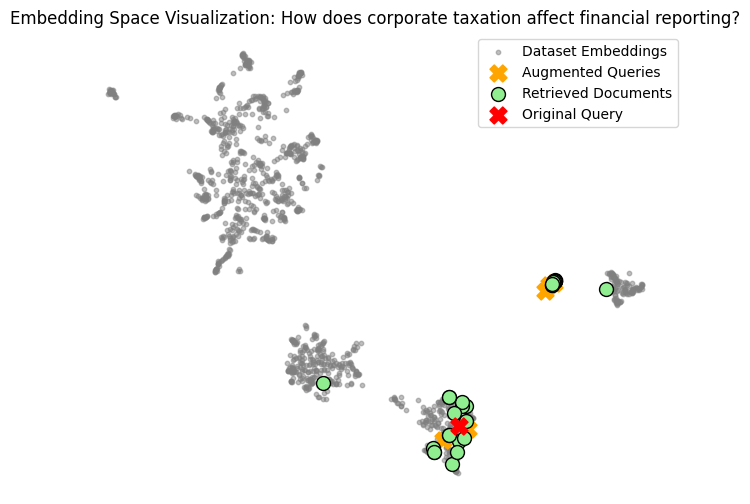

In [78]:

# Create plot
plt.figure(figsize=(8, 6))

# Plot dataset embeddings (gray background points)
plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
    alpha=0.5,
    label="Dataset Embeddings"
)

# Plot augmented queries (orange X markers)
plt.scatter(
    projected_augmented_queries[:, 0],
    projected_augmented_queries[:, 1],
    s=150,
    marker="X",
    color="orange",
    label="Augmented Queries"
)

# Plot retrieved document embeddings (green outlined circles)
plt.scatter(
    projected_result_embeddings[:, 0],
    projected_result_embeddings[:, 1],
    s=100,
    color="lightgreen",
    edgecolors="black",  # Fix warning
    label="Retrieved Documents"
)

# Plot original query (red X marker)
plt.scatter(
    projected_original_query[:, 0],
    projected_original_query[:, 1],
    s=150,
    marker="X",
    color="red",
    label="Original Query"
)

# Improve visualization readability
plt.gca().set_aspect("equal", "datalim")
plt.title(f"Embedding Space Visualization: {original_query}")
plt.axis("off")  # Hide axis for cleaner look
plt.legend()  # Add legend to clarify what’s plotted

# Show the plot
plt.show()